# Credit Car Fraud Detection with Hyper-parameter Tuning

This project is the extension of the project "Creditd Card Fraud Detection RF and KNN". We will use hyperperformance tuning to optimize hyperparameters of the decision tree and ensemble classifiers.

We will first use Classification Trees for predicting if a user has a default payment option active or not. Data source is [here](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) or via this link: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

This dataset is aimed at the case of customer default payments in Taiwan. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default.

In [2]:
## install specific version to read the excel file
!pip install xlrd==1.2.0

     |████████████████████████████████| 103 kB 7.7 MB/s eta 0:00:01
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Global functions

In [141]:
#required imports
import numpy as np
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [43]:
def check_balance(s, style="seaborn-pastel"):
  """ s: a series"""
  s_size = s.value_counts()
  print(s_size)
  plt.figure(figsize=(6,4))
  plt.pie(s_size,autopct = '%0.1f%%',explode=[0.05]*len(s_size), labels=s_size.index);
  plt.legend(['No','Yes'], title='Default',loc='upper right');

## Prepare data

### Read in data

After installing the necessary libraries, proceed to download the data. Since reading the excel file won't create headers by default, we added two more operations to substitute the columns.

In [44]:
#loading the data
dataset = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                        header=1,index_col='ID')
dataset.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

### Explore the data
In the following, you can take a look into the dataset.

In [126]:
dataset.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


0    23364
1     6636
Name: default payment next month, dtype: int64


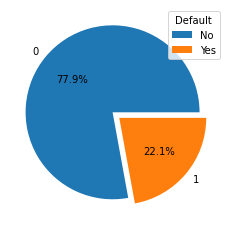

In [ ]:
# check data balance
check_balance(dataset['default payment next month'])

In [ ]:
print(f'Percentage of label 0: {round(sum(y==0)/len(y)*100,1)}%')
print(f'Percentage of label 1: {round(sum(y==1)/len(y)*100,1)}%')

Percentage of label 0: 77.9%
Percentage of label 1: 22.1%


Data is imbalanced, with 78% of the examples have label 0 and 22% label 1.

Missing values

In [ ]:
dataset[dataset.isna()].sum()

LIMIT_BAL                     0.0
SEX                           0.0
EDUCATION                     0.0
MARRIAGE                      0.0
AGE                           0.0
PAY_0                         0.0
PAY_2                         0.0
PAY_3                         0.0
PAY_4                         0.0
PAY_5                         0.0
PAY_6                         0.0
BILL_AMT1                     0.0
BILL_AMT2                     0.0
BILL_AMT3                     0.0
BILL_AMT4                     0.0
BILL_AMT5                     0.0
BILL_AMT6                     0.0
PAY_AMT1                      0.0
PAY_AMT2                      0.0
PAY_AMT3                      0.0
PAY_AMT4                      0.0
PAY_AMT5                      0.0
PAY_AMT6                      0.0
default payment next month    0.0
dtype: float64

There are no no missing values. Will deal with it later if furture dataset have missing values.

In [143]:
target = 'default payment next month'
predictor_vars = [col for col in dataset.columns if col not in [target]]
cat_vars = ['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numeric_vars = [col for col in predictor_vars if col not in cat_vars]

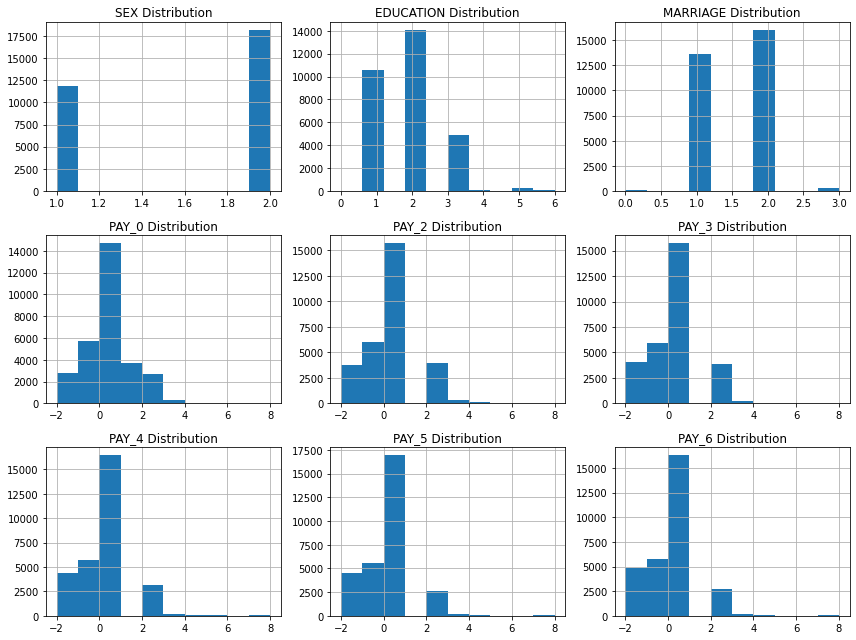

In [176]:
# Histogram of discrete variables
def draw_hists(df, features, n_rows=4, n_cols=2):
  fig=plt.figure(figsize=(4*n_cols,3*n_rows))
  for i, feature in enumerate(features):
      ax=fig.add_subplot(n_rows,n_cols,i+1)
      df[feature].hist(bins=10,ax=ax)
      ax.set_title(feature+" Distribution")
  fig.tight_layout()  # Improves appearance a bit.

draw_hists(dataset,cat_vars, n_rows=3, n_cols=3)

### Build Data processing pipeline

In [144]:
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [145]:
cat_pipe = Pipeline([('ohe',OneHotEncoder(sparse=False,handle_unknown='ignore')) ])
num_pipe = Pipeline([('scale',RobustScaler())])

pipeline_data = ColumnTransformer([('cat_tsfm',cat_pipe,cat_vars),
                                   ('num_tsfm',num_pipe,numeric_vars)
                                   ])

### Process data

In [146]:
X = dataset.iloc[:,0:-1].copy()
y = dataset.iloc[:,-1].copy()

In [147]:
X_train, X_test, y_train,y_test = train_test_split(X,y,random_state=10086)
X_train.shape, X_test.shape

((22500, 23), (7500, 23))

In [148]:
pipeline_data.fit(X_train)
X_train_transformed = pipeline_data.transform(X_train)
X_test_transformed = pipeline_data.transform(X_test)
print(f"X_train_transformed.shape: {X_train_transformed.shape}")
print(f"X_test_transformed.shape: {X_test_transformed.shape}")

X_train_transformed.shape: (22500, 91)
X_test_transformed.shape: (7500, 91)


## Decision tree
### Decision tress with different hyperparameter valuse

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, loguniform

from sklearn.metrics import f1_score, roc_auc_score
from time import time

In [185]:
tree_clf_1 = DecisionTreeClassifier(max_depth=10, random_state=10086,                            
                                  criterion='entropy').fit(X_train_transformed,y_train)                                
y_pred_1 = tree_clf_1.predict(X_test_transformed)
tree_clf_2 = DecisionTreeClassifier(max_depth=20, random_state=10086,                             
                                  criterion='entropy').fit(X_train_transformed,y_train)
y_pred_2 = tree_clf_2.predict(X_test_transformed)
tree_clf_3 = DecisionTreeClassifier(max_depth=10, random_state=10086,                              
                                  criterion='gini').fit(X_train_transformed,y_train)
y_pred_3 = tree_clf_3.predict(X_test_transformed)
tree_clf_4 = DecisionTreeClassifier(max_depth=20, random_state=10086,                              
                                  criterion='gini').fit(X_train_transformed,y_train)
y_pred_4 = tree_clf_4.predict(X_test_transformed)


In [186]:
from sklearn.metrics import confusion_matrix
print(f'Confusion matrix of tree_clf_1:\n {confusion_matrix(y_test, y_pred_1, labels=[0,1])}')
print(f'Confusion matrix of tree_clf_2:\n {confusion_matrix(y_test, y_pred_2, labels=[0,1])}')
print(f'Confusion matrix of tree_clf_3:\n {confusion_matrix(y_test, y_pred_3, labels=[0,1])}')
print(f'Confusion matrix of tree_clf_4:\n {confusion_matrix(y_test, y_pred_4, labels=[0,1])}')


Confusion matrix of tree_clf_1:
 [[5584  274]
 [1078  564]]
Confusion matrix of tree_clf_2:
 [[5109  749]
 [ 983  659]]
Confusion matrix of tree_clf_3:
 [[5482  376]
 [1008  634]]
Confusion matrix of tree_clf_4:
 [[5079  779]
 [1003  639]]


When max_depth is kept constant, Using Gini as criterion appears to have comparable results.<br>
When using the same criterion, increasing max_depth gives significantly lower true negatives (5584->5109, 5482->5079), but somewhat higher true positives (564->659, 634->639), and significantly increases false postives (models clf_1 vs. clf_2, clf_3 vs. clf_4). <br>
Since the data is imbalanced, accuracy is not an appropriate metric to evaluate the performance. But we can use F1 score to compare these models. <br>
F1 = 2 * (precision * recall) / (precision + recall)

In [187]:
[tn1, fp1], [fn1, tp1] = confusion_matrix(y_test, y_pred_1)
[tn2, fp2], [fn2, tp2] = confusion_matrix(y_test, y_pred_2)
[tn3, fp3], [fn3, tp3] = confusion_matrix(y_test, y_pred_3)
[tn4, fp4], [fn4, tp4] = confusion_matrix(y_test, y_pred_4)

In [188]:
prec1 = tp1/(tp1+fp1)
rec1 = tp1/(tp1+fn1)
F1_1 = 2*prec1*rec1/(prec1+rec1)
prec2 = tp2/(tp2+fp2)
rec2 = tp2/(tp2+fn2)
F1_2 = 2*prec2*rec2/(prec2+rec2)
prec3 = tp3/(tp3+fp3)
rec3 = tp3/(tp3+fn3)
F1_3 = 2*prec3*rec3/(prec3+rec3)
prec4 = tp4/(tp4+fp4)
rec4 = tp4/(tp4+fn4)
F1_4 = 2*prec4*rec4/(prec4+rec4)

print(f'tree_clf_1: precision = {round(prec1,2)}  recall = {round(rec1,2)}  F1 = {round(F1_1,2)} ')
print(f'tree_clf_2: precision = {round(prec2,2)}  recall = {round(rec2,2)}  F1 = {round(F1_2,2)}')
print(f'tree_clf_3: precision = {round(prec3,2)}  recall = {round(rec3,2)}  F1 = {round(F1_3,2)}')
print(f'tree_clf_4: precision = {round(prec4,2)}  recall = {round(rec4,2)}  F1 = {round(F1_4,2)}')

tree_clf_1: precision = 0.67  recall = 0.34  F1 = 0.45 
tree_clf_2: precision = 0.47  recall = 0.4  F1 = 0.43
tree_clf_3: precision = 0.63  recall = 0.39  F1 = 0.48
tree_clf_4: precision = 0.45  recall = 0.39  F1 = 0.42


In [260]:
y_pred_1_prob = tree_clf_1.predict_proba(X_test_transformed)
y_pred_2_prob = tree_clf_2.predict_proba(X_test_transformed)
y_pred_3_prob = tree_clf_3.predict_proba(X_test_transformed)
y_pred_4_prob = tree_clf_4.predict_proba(X_test_transformed)
print(f'tree_clf_1 decision tree roc_auc score = {roc_auc_score(y_test, y_pred_1_prob[:,1])}')
print(f'tree_clf_2 decision tree roc_auc score = {roc_auc_score(y_test, y_pred_2_prob[:,1])}')
print(f'tree_clf_3 decision tree roc_auc score = {roc_auc_score(y_test, y_pred_3_prob[:,1])}')
print(f'tree_clf_4 decision tree roc_auc score = {roc_auc_score(y_test, y_pred_4_prob[:,1])}')

tree_clf_1 decision tree roc_auc score = 0.7316344721960121
tree_clf_2 decision tree roc_auc score = 0.643413298656927
tree_clf_3 decision tree roc_auc score = 0.7343593341231726
tree_clf_4 decision tree roc_auc score = 0.6040501158352216


Criterion does not affect decision tree classification model performance in terms of F1 score.<br>

However, max_depth does affect performance, with in this case, higher max_depth resulted in lower F1 score and roc_auc score. Increasing max_depth increased recall - the percent of true postives in all positive cases - by 3% but at the cost of decreasing precision by 16% - 19%. <br>

### Hyper-parameter tuning with RandomizedSearchCV

In [37]:
param_dt = {'max_depth':randint(5,30),
              'max_features':randin(5,X.shape[1]+1),
              'criterion':['gini','entropy'],
              'min_samples_split':randint(5, 100)    
}

In [38]:
time0=time()
dt_rscv = RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                             param_distributions=param_dt,
                             n_iter=20,
                             scoring='roc_auc',
                             cv=5,
                             n_jobs=-1,
                             verbose=1,
                             random_state=10086)
dt_rscv.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-time0)/60,4)} minutes')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Time elapsed: 0.1558 minutes


In [39]:
# Save the model
# joblib.dump(dt_rscv,r'drive/My Drive/DS4-ML/Assignment 4 dt_rscv randomizedsearchcv decisiontree.joblib')
# dt_rscv = joblib.load(r'drive/My Drive/DS4-ML/Assignment 4 dt_rscv randomizedsearchcv decisiontree.joblib')

In [40]:
dt_rscv.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=20,
                       min_samples_split=45)

In [42]:
y_pred_dt = dt_rscv.best_estimator_.predict(X_test_transformed)
y_pred_dt_prob = dt_rscv.best_estimator_.predict_proba(X_test_transformed)
print(f'dt_clf decision tree F1 score = {f1_score(y_test, y_pred_dt)}')
print(f'dt_clf decision tree roc_auc score = {roc_auc_score(y_test, y_pred_dt_prob[:,1])}')

dt_clf decision tree F1 score = 0.45319812792511693
dt_clf decision tree roc_auc score = 0.7529305001145669


The f1 score is somehow lower than in the Q1 model tree_clf_3. Since the tuning is to maximize the roc_auc score, therefore hypertuning produced a slightly better roc_auc score (roc_auc = 0.75) than the best model in Q1 (roc_auc = 0.73).

## Ensemble classifiers
In this section, we will build the same classifier by using following ensemble models.
* Random Forest 
* AdaBoost
* Extra Trees Classifier 
* Gradient Boosted Trees 


In [151]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier

For all the ensemble models mentioned above, we will first tune the hyperparameters (optimized for roc_auc score) then use the best estimator to fit the model and calculate roc_auc score.

#### Random Forest


##### ***No hyperparam tuning***

In [157]:
rf_clf = RandomForestClassifier(random_state=10086)
rf_clf.fit(X_train_transformed,y_train)

y_pred_rf_clf = rf_clf.predict(X_test_transformed)
y_pred_rf_clf_prob = rf_clf.predict_proba(X_test_transformed)
print(f'rf_clf RandomForest f1 score = {f1_score(y_test,y_pred_rf_clf)}')
print(f'rf_clf RandomForest roc_auc score = {roc_auc_score(y_test,y_pred_rf_clf_prob[:,1])}')

rf_clf RandomForest f1 score = 0.4717710750193349
rf_clf RandomForest roc_auc score = 0.7707986704420369


##### ***Hyperparam tuning***

In [23]:
time0=time()
param_rf = {'n_estimators':randint(200,500),
            'max_depth':randint(5,30),
            'max_features':randint(5,X.shape[1]+1)
            'criterion':['gini','entropy'],
            'min_samples_split':randint(5,100)}
rf_rscv = RandomizedSearchCV(RandomForestClassifier(random_state=10086),
                             param_distributions=param_rf,
                             n_iter=20,
                             scoring='roc_auc',
                             verbose=1,
                             cv=5,
                             n_jobs=-1,
                             random_state=10086)
rf_rscv.fit(X_train_transformed, y_train)
print(f'TIme elapsed: {round((time()-time0)/60,2)} minutes')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
TIme elapsed: 16.82 minutes


In [25]:
# Save the model
# joblib.dump(rf_rscv,r'drive/My Drive/DS4-ML/Assignment 4 rf_rscv randomizedsearchcv randomforest.joblib')
# rf_rscv = joblib.load(r'drive/My Drive/DS4-ML/Assignment 4 rf_rscv randomizedsearchcv randomforest.joblib')

['drive/My Drive/DS4-ML/Assignment 4 rf_rscv randomizedsearchcv randomforest.joblib']

In [50]:
rf_rscv.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=20, max_features=10,
                       min_samples_split=25, n_estimators=350,
                       random_state=10086)

In [51]:
y_pred_rf = rf_rscv.best_estimator_.predict(X_test_transformed)
y_pred_rf_prob = rf_rscv.best_estimator_.predict_proba(X_test_transformed)
print(f'rf_rscv RandomForest f1 score = {f1_score(y_test,y_pred_rf)}')
print(f'rf_rscv RandomForest roc_auc score = {roc_auc_score(y_test,y_pred_rf_prob[:,1])}')

rf_rscv RandomForest f1 score = 0.47328848436881676
rf_rscv RandomForest roc_auc score = 0.7878776080598525


The f1_score is not improved by random forest with the prarameter grid used in randomized search cross validation. <br>

The roc_auc score (0.79) is higher than DecisionTree with tuned hyparameters, 0.77.

#### AdaBoost
We will first tune the hyperparameters then use the best estimator to fit the model and calculate roc_auc score.

##### ***No hyperparam tuning***

In [52]:
# No CV search
time0 = time()
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                             n_estimators=250, learning_rate=0.5,
                             random_state=10086)
ada_clf.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round(time()-time0,2)} seconds')

Time elapsed: 16.41 seconds


In [53]:
y_pred_ada_clf = ada_clf.predict(X_test_transformed)
y_pred_ada_clf_prob = ada_clf.predict_proba(X_test_transformed)
print(f'ada_clf AdaBoost f1 score = {f1_score(y_test,y_pred_ada_clf)}')
print(f'ada_clf  AdaBoost roc_auc score = {roc_auc_score(y_test, y_pred_ada_clf_prob[:,1])}')

ada_clf AdaBoost f1 score = 0.4581320450885668
ada_clf  AdaBoost roc_auc score = 0.7796592020073946


##### ***Hyperparam tuning***

In [247]:
# With RandomizedSearchCV
time0 = time()
param_ada = {'n_estimators':randint(200,500),
             'learning_rate':loguniform(0.01,2.0)}
ada_rscv = RandomizedSearchCV(AdaBoostClassifier(),
                              param_distributions=param_ada,
                              n_iter=20,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              random_state=10086)
ada_rscv.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-time0)/60,2)} seconds')

Time elapsed: 1624.63 seconds


In [27]:
# Save the model
# joblib.dump(ada_rscv,r'drive/My Drive/DS4-ML/Assignment 4 ada_rscv randomizedsearchcv AdaBoost.joblib')
# ada_rscv = joblib.load(r'drive/My Drive/DS4-ML/Assignment 4 ada_rscv randomizedsearchcv AdaBoost.joblib')

In [54]:
ada_rscv.best_estimator_

AdaBoostClassifier(learning_rate=0.1, n_estimators=400)

In [56]:
y_pred_ada = ada_rscv.best_estimator_.predict(X_test_transformed)
y_pred_ada_prob = ada_rscv.best_estimator_.predict_proba(X_test_transformed)
print(f'ada_rscv AdaBoost f1 score = {f1_score(y_test,y_pred_ada)}')
print(f'ada_rscv AdaBoost roc_auc score = {roc_auc_score(y_test, y_pred_ada_prob[:,1])}')

ada_rscv AdaBoost f1 score = 0.4380952380952381
ada_rscv AdaBoost roc_auc score = 0.7840302610419807


AdaBoost has a lower F1 score and comparable roc_auc score than the RandomForest model.

#### Extra Tree

##### ***No hyperparam tuning***

In [269]:
# No CV search
time0 = time()
xtr_clf = ExtraTreesClassifier(n_estimators=250, criterion='entropy',max_depth=20,
                             random_state=10086)
xtr_clf.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round(time()-time0,2)} seconds')

Time elapsed: 9.55 seconds


In [271]:
y_pred_xtr_clf = xtr_clf.predict(X_test_transformed)
y_pred_xtr_clf_prob = xtr_clf.predict_proba(X_test_transformed)
print(f'xtr_clf AdaBoost f1 score = {f1_score(y_test,y_pred_xtr_clf)}')
print(f'xtr_clf AdaBoost roc_auc score = {roc_auc_score(y_test, y_pred_xtr_clf_prob[:,1])}')

xtr_clf AdaBoost f1 score = 0.47026816945200156
xtr_clf AdaBoost roc_auc score = 0.7716162329828682


##### ***Hyperparam tuning***

In [28]:
# With RandomizedSearchCV
time0 = time()
param_xtr ={'n_estimators':randint(200,500),
            'max_depth':randint(5,30),
            'max_features':randint(5,X.shape[1]+1)
            'criterion':['gini','entropy'],
            'min_samples_split':randint(5,100)}

xtr_rscv = RandomizedSearchCV(ExtraTreesClassifier(),
                              param_distributions=param_xtr,
                              n_iter=20,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              random_state=10086)
xtr_rscv.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-time0)/60,2)} minutes')

Time elapsed: 8.89 minutes


In [30]:
# Save the model
# joblib.dump(xtr_rscv,r'drive/My Drive/DS4-ML/Assignment 4 xtr_rscv randomizedsearchcv ExtraTree.joblib')
# xtr_rscv = joblib.load(r'drive/My Drive/DS4-ML/Assignment 4 xtr_rscv randomizedsearchcv ExtraTree.joblib')

['drive/My Drive/DS4-ML/Assignment 4 xtr_rscv randomizedsearchcv ExtraTree.joblib']

In [57]:
xtr_rscv.best_estimator_

ExtraTreesClassifier(max_depth=20, max_features=20, min_samples_split=85,
                     n_estimators=200)

In [58]:
y_pred_xtr = xtr_rscv.best_estimator_.predict(X_test_transformed)
y_pred_xtr_prob = xtr_rscv.best_estimator_.predict_proba(X_test_transformed)
print(f'xtr_rscv ExtraTree f1 score = {f1_score(y_test,y_pred_xtr)}')
print(f'xtr_rscv ExtraTree roc_auc score = {roc_auc_score(y_test, y_pred_xtr_prob[:,1])}')

xtr_rscv ExtraTree f1 score = 0.47667984189723317
xtr_rscv ExtraTree roc_auc score = 0.7806037549657776


ExtraTreeClassifier has a similar F1 score and roc_auc score to the RandomForest and AdaBoost models.

#### Gradient Boosting

##### ***No hyperparam tuning***

In [61]:
# No CV search
time0 = time()
gbc_clf = GradientBoostingClassifier(random_state=10086)
gbc_clf.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round(time()-time0,2)} seconds')

Time elapsed: 14.74 seconds


In [62]:
y_pred_gbc_clf = gbc_clf.predict(X_test_transformed)
y_pred_gbc_clf_prob = gbc_clf.predict_proba(X_test_transformed)
print(f'gbc_clf GradientBoost f1 score = {f1_score(y_test,y_pred_gbc_clf)}')
print(f'gbc_clf GradientBoost roc_auc score = {roc_auc_score(y_test, y_pred_gbc_clf_prob[:,1])}')

gbc_clf GradientBoost f1 score = 0.4725838264299803
gbc_clf GradientBoost roc_auc score = 0.7863605326049845


##### ***Hyperparam tuning***

In [291]:
# With RandomizedSearchCV
time0 = time()
param_gbc = {'n_estimators':randint(200,500),
             'learning_rate':loguniform(0.01,2),
             'max_depth':randint(5,30),
             'max_features':randint(5,X.shape[1]+1)
             'min_samples_split':randint(5,100)}

gbc_rscv = RandomizedSearchCV(GradientBoostingClassifier(),
                              param_distributions=param_gbc,
                              n_iter=20,
                              scoring='roc_auc',
                              cv=5,
                              n_jobs=-1,
                              verbose=0,
                              random_state=10086)
gbc_rscv.fit(X_train_transformed, y_train)
print(f'Time elapsed: {round((time()-time0/60),2)} seconds')

Time elapsed: 899.51 seconds


In [32]:
# Save the model
# joblib.dump(gbc_rscv,r'drive/My Drive/DS4-ML/Assignment 4 gbc_rscv randomizedsearchcv GradientBoost.joblib')
# gbc_rscv = joblib.load(r'drive/My Drive/DS4-ML/Assignment 4 gbc_rscv randomizedsearchcv GradientBoost.joblib')

In [59]:
gbc_rscv.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_depth=10, max_features=20,
                           min_samples_split=85)

In [64]:
y_pred_gbc = gbc_rscv.best_estimator_.predict(X_test_transformed)
y_pred_gbc_prob = gbc_rscv.best_estimator_.predict_proba(X_test_transformed)
print(f'gbc_rscv GradientBoost f1 score = {f1_score(y_test,y_pred_gbc)}')
print(f'gbc_rscv GradientBoost roc_auc score = {roc_auc_score(y_test, y_pred_gbc_prob[:,1])}')

gbc_rscv GradientBoost f1 score = 0.3507951356407858
gbc_rscv GradientBoost roc_auc score = 0.787303162253728


F1 score is lower than other models, and roc_auc score is similar to other models.

#### ROC_AUC curves comparison

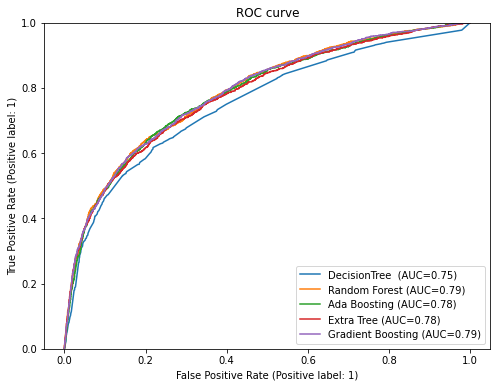

In [65]:
from sklearn.metrics import RocCurveDisplay

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
RocCurveDisplay.from_estimator(dt_rscv, X_test_transformed, y_test, ax=ax);
RocCurveDisplay.from_estimator(rf_rscv, X_test_transformed, y_test, ax=ax);
RocCurveDisplay.from_estimator(ada_rscv, X_test_transformed, y_test, ax=ax);
RocCurveDisplay.from_estimator(xtr_rscv, X_test_transformed, y_test, ax=ax);
RocCurveDisplay.from_estimator(gbc_rscv, X_test_transformed, y_test, ax=ax);
plt.legend(['DecisionTree  (AUC={})'.format(round(roc_auc_score(y_test, y_pred_dt_prob[:,1]),2)),
            'Random Forest (AUC={})'.format(round(roc_auc_score(y_test, y_pred_rf_prob[:,1]),2)),
            'Ada Boosting (AUC={})'.format(round(roc_auc_score(y_test, y_pred_ada_prob[:,1]),2)),
            'Extra Tree (AUC={})'.format(round(roc_auc_score(y_test, y_pred_xtr_prob[:,1]),2)),
            'Gradient Boosting (AUC={})'.format(round(roc_auc_score(y_test, y_pred_gbc_prob[:,1]),2))], 
           loc='lower right')
plt.title('ROC curve')
plt.ylim(0,1);

ROC curve shows that all ensemble methods have a similar performance in terms of ROC curve. They all perform better than hyperparameter tuned DecisionTree model.

#### Learning curves

In [42]:
# download from GitHub repository
import requests

# Get the "Raw" version of the code from GitHub
url = 'https://raw.githubusercontent.com/TessieTong/ds4ml/main/plot_learning_curve.py'
r = requests.get(url)

# Write to Colab working directory 
with open('plot_learning_curve.py', 'w') as f:
    f.write(r.text)

# import
from plot_learning_curve import plot_learning_curve

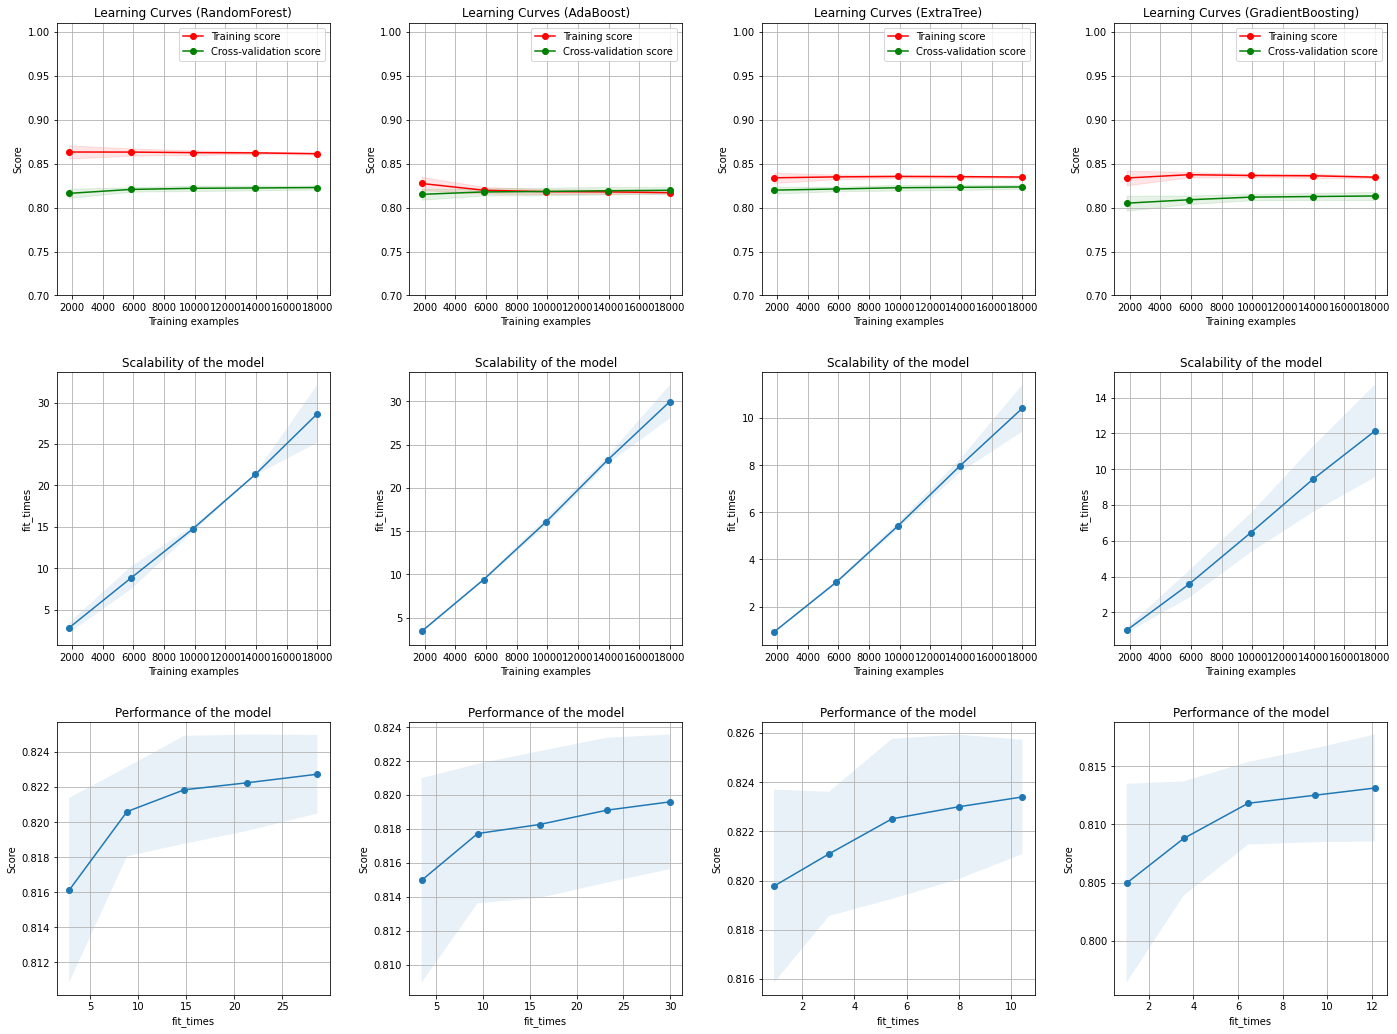

In [77]:
# Plot learning curves of the 4 best ensemble classifiers
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
# Cross validation with 10 iterations
# score curves, each time with 20% data randomly selected as a validation set.
# Here only the training set is used.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=10086)

title = r"Learning Curves (RandomForest)"
plot_learning_curve(rf_rscv.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (AdaBoost)"
plot_learning_curve(ada_rscv.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (ExtraTree)"
plot_learning_curve(xtr_rscv.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 2], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

title = r"Learning Curves (GradientBoosting)"
plot_learning_curve(gbc_rscv.best_estimator_,
    title, X_train_transformed, y_train, 
    axes=axes[:, 3], ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.tight_layout(pad=3.0)
plt.show();

## Discussions

1. **Changing hyperparameters affects model performance**. As demoned in Q1, 4 combinations of hyperparam were considered to train a decision tree. The results, i.e., performance metrics, including confusion matrix, precision, recall, f1 score and roc_auc score, were all somehow different to different degrees, with some more comparable than others.  <br>
Hyparameters tuned with randomizedSearchCV method do not always produce the best solution but a good enough soution. For example, tuned hyperparams for DecisionTree from Q2 has a higher roc_auc score than the ones from Q1. Since the tuning is to maxmize the roc_auc score, it's expected that F1 score may be not higher the those from Q1.<br>
If roc_auc is the sole metrics to evaluate the models, from the above analyses, all 4 ensemble methods had an equal performance.

2. **While all 4 ensemble methods had the same performance in terms of roc_auc score, they did not perform eaqually well in terms of learning curve**. As shown in the ***Learning Curves*** section of Q3, *Random Forest* appeared slightly overfitting consistently, so as *Gradient Boosting* but to a lesser degree. *AdaBoost* had almost the same predictions on both train and test sets, except at the lowest numbers of the train examples. In addition, it appears the ***AdaBoost*** also has the highest model scalability (fit-times increase more sharply with increasing number of training examples). ***ExtraTree*** has the best model performance (achieves highest score with lowest fit-times).<br>

    - It is worth noting that the difference in performance are very small among all these 4 models. And it appearred that 6,000 examples can achieve the highest score for all models.

3. **The performace of the models as shown in the learning curves is in line with the known strength and weakness of the models**. <br>

    - For example, DecisionTree tends to very easily ovefit. Ensemble methods based on it are prone to overfitting. Although it has mechanisms to limit overfitting, such as randomly selecting a subset of features at each step to decrease the variance, RandomForest is still very easily overfit. On the other hand, ExtraTree take the randomization to an extreme level, further decrease the variance and avoid overfitting. <br>

    - Boosting algarithms learn sequentially, usually slow and cannot take advantage of parallel computing. Adaboost is not prone to overfitting, as the learning curve has shown. It also requires quality data, and extremely sensitive to noise and outliers. <br>

    - Gradient boosting fits on the remaining error of previous predictor and also learns sequentially. It is flexible and no need of data preprocessing (even handling missing values). As it continue improving to minimize all errors by randomly selecting a subset of feature at each ietration, it can overemphasize outliers and cause overfitting. As shown in the learning curve, it has the second largest gaps in model score between training and cross-validation, which suggests overfitting.


# **-- END --**